## We will only use here 3x5 grid instead of fine grid 30x80

In [18]:
# %tensorflow_version 2.x  # this line is not required unless you are in a notebook
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
# matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
import os
PROJECT_DIR = "../../"
os.makedirs("./results/03x05-coarse-grid/",exist_ok=True)

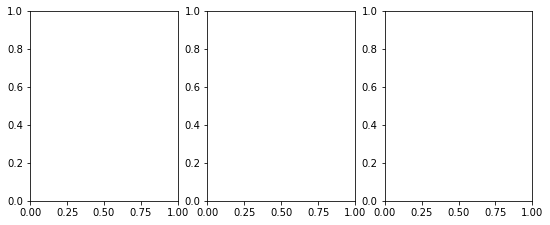

In [20]:
fig, axes = plt.subplots(1, 3)
fig.set_facecolor("White")
fig.set_size_inches(9, 3.5)

# fig.tight_layout(pad=0.1)


In [21]:
def reset_fig():
    for ax in axes:
        ax.cla()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Target")
        # ratio = 1.0
        # x_left, x_right = ax.get_xlim()
        # y_low, y_high = ax.get_ylim()
        # ax.set_aspect("equal")
    axes[0].set_title("Train")
    axes[1].set_title("Validation")
    axes[2].set_title("Test")
    fig.suptitle("Hello")
    fig.subplots_adjust(
        left=0.075,
        right=0.975,
        top=0.85,
        bottom=0.15,
        wspace=0.3, hspace=0)


## Prepare Dataset

In [23]:
alldata_15G = np.loadtxt(f'{PROJECT_DIR}/raw/alldata_15G.dat',dtype=np.float32)

## Split Train, validation, test

In [24]:
FIG_NO=0
FEATURES = 15
STRAIN, TOUGHNESS, STRESS = -3, -2, 1
prop=STRAIN
max_prop = np.max(alldata_15G[:, STRAIN])

inputs = torch.from_numpy(alldata_15G[:, 0:FEATURES]).float().reshape(-1,1,3,5)
targets = torch.from_numpy(alldata_15G[:, prop]/max_prop).float().reshape(-1,1)
print(targets.dtype,inputs.dtype)
dataset = TensorDataset(inputs, targets)
train_ds, val_ds, test_ds = random_split(dataset, [23833, 2979, 2979])
len(train_ds), len(val_ds), len(test_ds)
# Shuffle the data although not needed as it is already suffled
# np.random.shuffle(alldata_15G)


torch.float32 torch.float32


(23833, 2979, 2979)

## DataLoader and Batch Size

In [25]:
batch_size = 200
train_dl = DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size,pin_memory=True)
test_dl = DataLoader(test_ds,batch_size)

## Regression Model

In [26]:
class KirigamiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding="same"),
            nn.ReLU(),              
            # nn.MaxPool2d(2, 2),  # output: 16 x 3 x 5

            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2),  # output: 32 x 3 x 5

            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2),  # output: 64 x 3 x 5

            nn.Flatten(),
            nn.Linear(960,64),
            nn.ReLU(),
            nn.Linear(64,1),
        )

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, targets = batch
        preds = self(images)                  # Generate predictions
        loss = F.mse_loss(preds, targets)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, targets = batch
        preds = self(images)                    # Generate predictions
        loss = F.mse_loss(preds, targets)       # Calculate loss
        # acc = accuracy(preds, targets)        # Calculate accuracy
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        # batch_accs = [x['val_acc'] for x in outputs]
        # epoch_acc = torch.stack(batch_accs).mean()    # Combine accuracies
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

model = KirigamiModel()
# trial_input = torch.rand((4,1,30,80))
# print(trial_input.dtype)
# model(trial_input).shape


In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(model, device)

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            imgs, targets = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
history=[]

In [30]:
for i in range(num_epochs):
    history = fit(1, lr, model, train_dl, val_dl, opt_func)
    reset_fig()

    for imgs,targets in train_dl:
        axes[0].plot(model(imgs).detach().cpu(),targets.cpu(),"k.")
        axes[0].plot([0,1],[0,1],"r--")

    for imgs,targets in val_dl:
        axes[1].plot(model(imgs).detach().cpu(),targets.cpu(),"k.")
        axes[1].plot([0,1],[0,1],"r--")


    for imgs,targets in test_dl:
        axes[2].plot(model(imgs).detach().cpu(),targets.cpu(),"k.")
        axes[2].plot([0,1],[0,1],"r--")
    fig.suptitle(f"Epoch: {FIG_NO:02d}")
    fig.savefig(F"./results/03x05-coarse-grid/epoch-{FIG_NO:02d}.png",dpi=300)
    FIG_NO+=1

Epoch [0], train_loss: 0.0003, val_loss: 0.0005
Epoch [0], train_loss: 0.0002, val_loss: 0.0005
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0005
Epoch [0], train_loss: 0.0002, val_loss: 0.0005
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss: 0.0006
Epoch [0], train_loss: 0.0002, val_loss:

## Save the model

In [32]:
import os
os.makedirs("./models/regression",exist_ok=True)
torch.save(model.state_dict(), './models/regression/f16-f32-f64-h64-3x5-coarse-grid.pth')
